In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import importlib, import_ipynb
import data_clean_order as data
import tensorflow as tf
from tensorflow.data import experimental
from tensorflow import keras
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split, cross_val_score
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

# model building imports
from keras.layers import Embedding, Flatten, Dense, Dropout
from keras.layers import Conv1D, SimpleRNN, Bidirectional, MaxPooling1D, GlobalMaxPool1D, LSTM, GRU
from keras.models import Sequential
from keras.regularizers import L1L2

%matplotlib inline

# matplotlib defaults
plt.style.use("ggplot")
plt.rc("figure", autolayout=True)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)

import warnings 
warnings.filterwarnings('ignore')

importing Jupyter notebook from data_clean_order.ipynb
Length of original data set 209527
Number of examples with no short description:  19712
Number of examples with no headline:  6


c:\Users\natal\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
c:\Users\natal\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
c:\Users\natal\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
c:\Users\natal\anacond

Stored 'test_df' (DataFrame)
Size of training data for headlines:  167616
Size of testing data for headlines:  41905
Size of training data for headlines:  151851
Size of testing data for headlines:  37963
Stored 'ordered_super_alpha_text' (DataFrame)
Stored 'ordered_class_alpha_text' (DataFrame)
Stored 'ordered_sem_clusters_desc_text' (DataFrame)
Stored 'ordered_sem_clusters_asc_text' (DataFrame)
Stored 'ordered_sem_clusters_shuffled_per_superclass_text' (DataFrame)


In [2]:
%store -r ordered_super_alpha_text
%store -r ordered_class_alpha_text
%store -r ordered_sem_clusters_desc_text
%store -r ordered_sem_clusters_asc_text
%store -r ordered_sem_clusters_shuffled_per_superclass_text
%store -r test_df

In [3]:
# Experimental data orderings on headlines TRAIN EXAMPLES
X1_train = ordered_super_alpha_text['cleaned_headline']
X2_train = ordered_class_alpha_text['cleaned_headline']
X3_train = ordered_sem_clusters_desc_text['cleaned_headline']
X4_train = ordered_sem_clusters_asc_text['cleaned_headline']
X5_train = ordered_sem_clusters_shuffled_per_superclass_text['cleaned_headline']

# Experimental data orderings on short_description #TODO

# TRAIN LABELS
Y1_train = ordered_super_alpha_text['class']
Y2_train = ordered_class_alpha_text['class']
Y3_train = ordered_sem_clusters_desc_text['class']
Y4_train = ordered_sem_clusters_asc_text['class']
Y5_train = ordered_sem_clusters_shuffled_per_superclass_text['class']

# TEST EXAMPLES
X_test = test_df['cleaned_headline']
Y_test = test_df['class']

## Tokenization and Vectorization


### One-hot encoding and indexing of train and test data

In [4]:
# TEST DATA

# one hot encoding using keras tokenizer and pad sequencing
encoder = LabelEncoder()
Y_test = encoder.fit_transform(Y_test)
print("shape of input data: ", X_test.shape)
print("shape of target variable: ", Y_test.shape)

tokenizer = Tokenizer(num_words=1000000, oov_token='<00V>') 
tokenizer.fit_on_texts(X_test) # build the word index
# padding X_test text input data
test_seq = tokenizer.texts_to_sequences(X_test) # converts strinfs into integer lists
test_padseq = pad_sequences(test_seq, maxlen=20) # pads the integer lists to 2D integer tensor 

word_index = tokenizer.word_index
max_words = 150000000  # total number of words to consider in embedding layer
total_words = len(word_index)
maxlen = 20 # max length of sequence 
Y_test = to_categorical(Y_test, num_classes=42)
print("Length of word index:", total_words)

shape of input data:  (41905,)
shape of target variable:  (41905,)
Length of word index: 27152


# EXPERIMENT ORDER 1

In [10]:
# ORDER 1 TRAIN DATA
X_train = X1_train
Y_train = Y1_train

# one hot encoding using keras tokenizer and pad sequencing
encoder = LabelEncoder()
Y_train = encoder.fit_transform(Y_train)
print("shape of input data: ", X_train.shape)
print("shape of target variable: ", Y_train.shape)

tokenizer = Tokenizer(num_words=1000000, oov_token='<00V>') 
tokenizer.fit_on_texts(X_train) # build the word index
# padding X_train text input data
train_seq = tokenizer.texts_to_sequences(X_train) # converts strinfs into integer lists
train_padseq = pad_sequences(train_seq, maxlen=20) # pads the integer lists to 2D integer tensor 

word_index = tokenizer.word_index
max_words = 15000000  # total number of words to consider in embedding layer
total_words = len(word_index) + 1000
maxlen = 20 # max length of sequence 
Y_train = to_categorical(Y_train, num_classes=42)
print("Length of word index:", total_words)

shape of input data:  (167616,)
shape of target variable:  (167616,)
Length of word index: 53599


### Model 2, training using Conv1D, Bi-directional RNN, LSTMs and GRU layer

In [11]:
model2 = Sequential()
model2.add(Embedding(total_words, 100, input_length=maxlen))
model2.add(Bidirectional(LSTM(64, dropout=0.1, recurrent_dropout=0.10, activation='tanh', return_sequences=True)))
model2.add(Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.20, activation='tanh', return_sequences=True)))
model2.add(Bidirectional(SimpleRNN(64, dropout=0.2, recurrent_dropout=0.20, activation='tanh', return_sequences=True)))
model2.add(Conv1D(72, 3, activation='relu'))
model2.add(MaxPooling1D(2))
model2.add(SimpleRNN(64, activation='tanh', dropout=0.2, recurrent_dropout=0.20, return_sequences=True))
model2.add(GRU(64, recurrent_dropout=0.20, recurrent_regularizer='l1_l2'))
model2.add(Dropout(0.2))
model2.add(Dense(42, activation='softmax'))
model2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 20, 100)           5359900   
                                                                 
 bidirectional (Bidirectiona  (None, 20, 128)          84480     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 20, 128)          98816     
 nal)                                                            
                                                                 
 bidirectional_2 (Bidirectio  (None, 20, 128)          24704     
 nal)                                                            
                                                                 
 conv1d (Conv1D)             (None, 18, 72)            27720     
                                                        

In [13]:
model2.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy']
              )
# SETUP A EARLY STOPPING CALL and model check point API
earlystopping = keras.callbacks.EarlyStopping(monitor='accuracy',
                                              patience=5,
                                              verbose=1,
                                              mode='min'
                                              )
checkpointer = ModelCheckpoint(filepath='bestvalue1',moniter='val_loss', verbose=0, save_best_only=True)
callback_list = [checkpointer, earlystopping]

# fit model to the data
history2 = model2.fit(train_padseq, Y_train, 
                     batch_size=128, 
                     epochs=15
                    )

# evalute the model
test_loss2, test_acc2 = model2.evaluate(test_padseq, Y_test, verbose=0)
print("test loss and accuracy:", test_loss2, test_acc2)

Epoch 1/15
1310/1310 [==============================] - 483s 343ms/step - loss: 2.8438 - accuracy: 0.3485
Epoch 2/15
1310/1310 [==============================] - 411s 314ms/step - loss: 2.0611 - accuracy: 0.4809
Epoch 3/15
1310/1310 [==============================] - 410s 313ms/step - loss: 1.8493 - accuracy: 0.5280
Epoch 4/15
1310/1310 [==============================] - 397s 303ms/step - loss: 1.7096 - accuracy: 0.5628
Epoch 5/15
1310/1310 [==============================] - 402s 307ms/step - loss: 1.6035 - accuracy: 0.5887
Epoch 6/15
1310/1310 [==============================] - 474s 362ms/step - loss: 1.5193 - accuracy: 0.6110
Epoch 7/15
1310/1310 [==============================] - 530s 405ms/step - loss: 1.4432 - accuracy: 0.6308
Epoch 8/15
1310/1310 [==============================] - 404s 308ms/step - loss: 1.3787 - accuracy: 0.6492
Epoch 9/15
1310/1310 [==============================] - 414s 316ms/step - loss: 1.3157 - accuracy: 0.6656
Epoch 10/15
1310/1310 [=======================

In [5]:
def plot_loss_accuracy(history):

    # create object of arrays of accuracy and loss
    acc = history.history['accuracy']
    #val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    #val_loss = history.history['val_loss']
    
    # number of epochs in our model
    epochs = range(1 ,len(acc) + 1)
    
    # call matplolib figure object and plot loss and accuracy curves
    plt.figure(figsize=(15,6))
    
    plt.subplot(121)
    plt.plot(epochs, acc, 'bo', label='Training acc')
    #plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title("Training and validation accuracy", fontsize=15)
    plt.xlabel('epochs', fontsize=14)
    plt.ylabel("accuracy", fontsize=14)
    plt.legend()
    
    plt.subplot(122)
    plt.plot(epochs, loss, 'bo', label='Training loss')
    #plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title("Training and validation loss", fontsize=15)
    plt.xlabel('epochs', fontsize=14)
    plt.ylabel("loss", fontsize=14)
    plt.legend()
    
    plt.show()

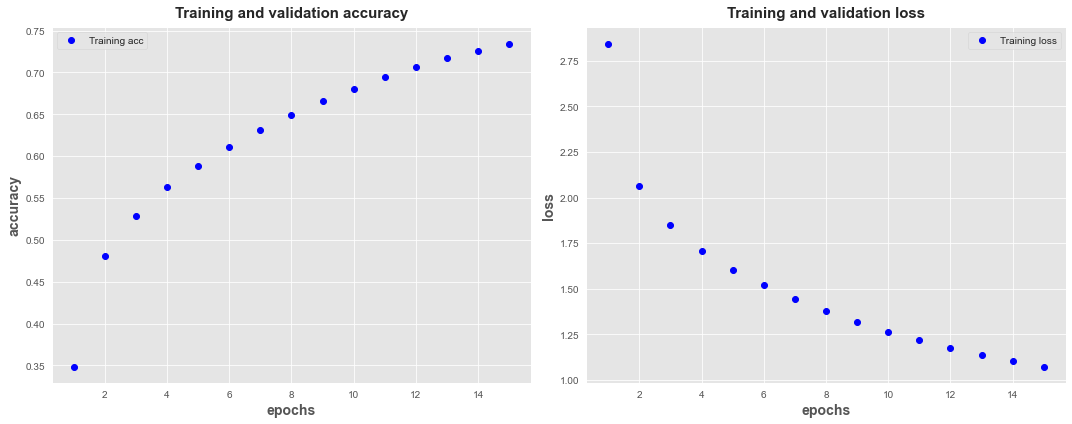

In [17]:
plot_loss_accuracy(history2)

# EXPERIMENT ORDER 2

In [ ]:
# ORDER 2 TRAIN DATA
X_train = X2_train
Y_train = Y2_train

# one hot encoding using keras tokenizer and pad sequencing
encoder = LabelEncoder()
Y_train = encoder.fit_transform(Y_train)
print("shape of input data: ", X_train.shape)
print("shape of target variable: ", Y_train.shape)

tokenizer = Tokenizer(num_words=1000000, oov_token='<00V>') 
tokenizer.fit_on_texts(X_train) # build the word index
# padding X_train text input data
train_seq = tokenizer.texts_to_sequences(X_train) # converts strinfs into integer lists
train_padseq = pad_sequences(train_seq, maxlen=20) # pads the integer lists to 2D integer tensor 

word_index = tokenizer.word_index
max_words = 15000000  # total number of words to consider in embedding layer
total_words = len(word_index) + 1000
maxlen = 20 # max length of sequence 
Y_train = to_categorical(Y_train, num_classes=42)
print("Length of word index:", total_words)

### Model 2, training using Conv1D, Bi-directional RNN, LSTMs and GRU layer

In [ ]:
model2 = Sequential()
model2.add(Embedding(total_words, 100, input_length=maxlen))
model2.add(Bidirectional(LSTM(64, dropout=0.1, recurrent_dropout=0.10, activation='tanh', return_sequences=True)))
model2.add(Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.20, activation='tanh', return_sequences=True)))
model2.add(Bidirectional(SimpleRNN(64, dropout=0.2, recurrent_dropout=0.20, activation='tanh', return_sequences=True)))
model2.add(Conv1D(72, 3, activation='relu'))
model2.add(MaxPooling1D(2))
model2.add(SimpleRNN(64, activation='tanh', dropout=0.2, recurrent_dropout=0.20, return_sequences=True))
model2.add(GRU(64, recurrent_dropout=0.20, recurrent_regularizer='l1_l2'))
model2.add(Dropout(0.2))
model2.add(Dense(42, activation='softmax'))
model2.summary()

In [ ]:
model2.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy']
              )
# SETUP A EARLY STOPPING CALL and model check point API
earlystopping = keras.callbacks.EarlyStopping(monitor='accuracy',
                                              patience=5,
                                              verbose=1,
                                              mode='min'
                                              )
checkpointer = ModelCheckpoint(filepath='bestvalue1',moniter='val_loss', verbose=0, save_best_only=True)
callback_list = [checkpointer, earlystopping]

# fit model to the data
history2 = model2.fit(train_padseq, y_train, 
                     batch_size=128, 
                     epochs=15
                    )

# evalute the model
test_loss2, test_acc2 = model2.evaluate(test_padseq, y_test, verbose=0)
print("test loss and accuracy:", test_loss2, test_acc2)

In [ ]:
plot_loss_accuracy(history2)

# EXPERIMENT ORDER 3

In [ ]:
# ORDER 3 TRAIN DATA
X_train = X3_train
Y_train = Y3_train

# one hot encoding using keras tokenizer and pad sequencing
encoder = LabelEncoder()
Y_train = encoder.fit_transform(Y_train)
print("shape of input data: ", X_train.shape)
print("shape of target variable: ", Y_train.shape)

tokenizer = Tokenizer(num_words=1000000, oov_token='<00V>') 
tokenizer.fit_on_texts(X_train) # build the word index
# padding X_train text input data
train_seq = tokenizer.texts_to_sequences(X_train) # converts strinfs into integer lists
train_padseq = pad_sequences(train_seq, maxlen=20) # pads the integer lists to 2D integer tensor 

word_index = tokenizer.word_index
max_words = 15000000  # total number of words to consider in embedding layer
total_words = len(word_index) + 1000
maxlen = 20 # max length of sequence 
Y_train = to_categorical(Y_train, num_classes=42)
print("Length of word index:", total_words)

### Model 2, training using Conv1D, Bi-directional RNN, LSTMs and GRU layer

In [ ]:
model2 = Sequential()
model2.add(Embedding(total_words, 100, input_length=maxlen))
model2.add(Bidirectional(LSTM(64, dropout=0.1, recurrent_dropout=0.10, activation='tanh', return_sequences=True)))
model2.add(Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.20, activation='tanh', return_sequences=True)))
model2.add(Bidirectional(SimpleRNN(64, dropout=0.2, recurrent_dropout=0.20, activation='tanh', return_sequences=True)))
model2.add(Conv1D(72, 3, activation='relu'))
model2.add(MaxPooling1D(2))
model2.add(SimpleRNN(64, activation='tanh', dropout=0.2, recurrent_dropout=0.20, return_sequences=True))
model2.add(GRU(64, recurrent_dropout=0.20, recurrent_regularizer='l1_l2'))
model2.add(Dropout(0.2))
model2.add(Dense(42, activation='softmax'))
model2.summary()

In [ ]:
model2.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy']
              )
# SETUP A EARLY STOPPING CALL and model check point API
earlystopping = keras.callbacks.EarlyStopping(monitor='accuracy',
                                              patience=5,
                                              verbose=1,
                                              mode='min'
                                              )
checkpointer = ModelCheckpoint(filepath='bestvalue1',moniter='val_loss', verbose=0, save_best_only=True)
callback_list = [checkpointer, earlystopping]

# fit model to the data
history2 = model2.fit(train_padseq, y_train, 
                     batch_size=128, 
                     epochs=15
                    )

# evalute the model
test_loss2, test_acc2 = model2.evaluate(test_padseq, y_test, verbose=0)
print("test loss and accuracy:", test_loss2, test_acc2)

In [ ]:
plot_loss_accuracy(history2)

# EXPERIMENT ORDER 4

In [18]:
# ORDER 4 TRAIN DATA
X_train = X4_train
Y_train = Y4_train

# one hot encoding using keras tokenizer and pad sequencing
encoder = LabelEncoder()
Y_train = encoder.fit_transform(Y_train)
print("shape of input data: ", X_train.shape)
print("shape of target variable: ", Y_train.shape)

tokenizer = Tokenizer(num_words=1000000, oov_token='<00V>') 
tokenizer.fit_on_texts(X_train) # build the word index
# padding X_train text input data
train_seq = tokenizer.texts_to_sequences(X_train) # converts strinfs into integer lists
train_padseq = pad_sequences(train_seq, maxlen=20) # pads the integer lists to 2D integer tensor 

word_index = tokenizer.word_index
max_words = 15000000  # total number of words to consider in embedding layer
total_words = len(word_index) + 1000
maxlen = 20 # max length of sequence 
Y_train = to_categorical(Y_train, num_classes=42)
print("Length of word index:", total_words)

shape of input data:  (167616,)
shape of target variable:  (167616,)
Length of word index: 53599


### Model 2, training using Conv1D, Bi-directional RNN, LSTMs and GRU layer


In [19]:
model2 = Sequential()
model2.add(Embedding(total_words, 100, input_length=maxlen))
model2.add(Bidirectional(LSTM(64, dropout=0.1, recurrent_dropout=0.10, activation='tanh', return_sequences=True)))
model2.add(Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.20, activation='tanh', return_sequences=True)))
model2.add(Bidirectional(SimpleRNN(64, dropout=0.2, recurrent_dropout=0.20, activation='tanh', return_sequences=True)))
model2.add(Conv1D(72, 3, activation='relu'))
model2.add(MaxPooling1D(2))
model2.add(SimpleRNN(64, activation='tanh', dropout=0.2, recurrent_dropout=0.20, return_sequences=True))
model2.add(GRU(64, recurrent_dropout=0.20, recurrent_regularizer='l1_l2'))
model2.add(Dropout(0.2))
model2.add(Dense(42, activation='softmax'))
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 20, 100)           5359900   
                                                                 
 bidirectional_3 (Bidirectio  (None, 20, 128)          84480     
 nal)                                                            
                                                                 
 bidirectional_4 (Bidirectio  (None, 20, 128)          98816     
 nal)                                                            
                                                                 
 bidirectional_5 (Bidirectio  (None, 20, 128)          24704     
 nal)                                                            
                                                                 
 conv1d_1 (Conv1D)           (None, 18, 72)            27720     
                                                      

In [20]:
model2.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy']
              )
# SETUP A EARLY STOPPING CALL and model check point API
earlystopping = keras.callbacks.EarlyStopping(monitor='accuracy',
                                              patience=5,
                                              verbose=1,
                                              mode='min'
                                              )
checkpointer = ModelCheckpoint(filepath='bestvalue1',moniter='val_loss', verbose=0, save_best_only=True)
callback_list = [checkpointer, earlystopping]

# fit model to the data
history2 = model2.fit(train_padseq, Y_train, 
                     batch_size=128, 
                     epochs=15
                    )

# evalute the model
test_loss2, test_acc2 = model2.evaluate(test_padseq, Y_test, verbose=0)
print("test loss and accuracy:", test_loss2, test_acc2)

Epoch 1/15


In [ ]:
plot_loss_accuracy(history2)

# EXPERIMENT ORDER 5

In [6]:
# ORDER 5 TRAIN DATA
X_train = X5_train
Y_train = Y5_train

# one hot encoding using keras tokenizer and pad sequencing
encoder = LabelEncoder()
Y_train = encoder.fit_transform(Y_train)
print("shape of input data: ", X_train.shape)
print("shape of target variable: ", Y_train.shape)

tokenizer = Tokenizer(num_words=1000000, oov_token='<00V>') 
tokenizer.fit_on_texts(X_train) # build the word index
# padding X_train text input data
train_seq = tokenizer.texts_to_sequences(X_train) # converts strinfs into integer lists
train_padseq = pad_sequences(train_seq, maxlen=20) # pads the integer lists to 2D integer tensor 

word_index = tokenizer.word_index
max_words = 15000000  # total number of words to consider in embedding layer
total_words = len(word_index) + 1000
maxlen = 20 # max length of sequence 
Y_train = to_categorical(Y_train, num_classes=42)
print("Length of word index:", total_words)

shape of input data:  (167616,)
shape of target variable:  (167616,)
Length of word index: 53672


### Model 2, training using Conv1D, Bi-directional RNN, LSTMs and GRU layer


In [7]:
model2 = Sequential()
model2.add(Embedding(total_words, 100, input_length=maxlen))
model2.add(Bidirectional(LSTM(64, dropout=0.1, recurrent_dropout=0.10, activation='tanh', return_sequences=True)))
model2.add(Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.20, activation='tanh', return_sequences=True)))
model2.add(Bidirectional(SimpleRNN(64, dropout=0.2, recurrent_dropout=0.20, activation='tanh', return_sequences=True)))
model2.add(Conv1D(72, 3, activation='relu'))
model2.add(MaxPooling1D(2))
model2.add(SimpleRNN(64, activation='tanh', dropout=0.2, recurrent_dropout=0.20, return_sequences=True))
model2.add(GRU(64, recurrent_dropout=0.20, recurrent_regularizer='l1_l2'))
model2.add(Dropout(0.2))
model2.add(Dense(42, activation='softmax'))
model2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 20, 100)           5367200   
                                                                 
 bidirectional (Bidirectiona  (None, 20, 128)          84480     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 20, 128)          98816     
 nal)                                                            
                                                                 
 bidirectional_2 (Bidirectio  (None, 20, 128)          24704     
 nal)                                                            
                                                                 
 conv1d (Conv1D)             (None, 18, 72)            27720     
                                                        

In [8]:
model2.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy']
              )
# SETUP A EARLY STOPPING CALL and model check point API
earlystopping = keras.callbacks.EarlyStopping(monitor='accuracy',
                                              patience=5,
                                              verbose=1,
                                              mode='min'
                                              )
checkpointer = ModelCheckpoint(filepath='bestvalue1',moniter='val_loss', verbose=0, save_best_only=True)
callback_list = [checkpointer, earlystopping]

# fit model to the data
history2 = model2.fit(train_padseq, Y_train, 
                     batch_size=128, 
                     epochs=15
                    )

# evalute the model
test_loss2, test_acc2 = model2.evaluate(test_padseq, Y_test, verbose=0)
print("test loss and accuracy:", test_loss2, test_acc2)

Epoch 1/15
1310/1310 [==============================] - 452s 313ms/step - loss: 2.8565 - accuracy: 0.3452
Epoch 2/15
1310/1310 [==============================] - 427s 326ms/step - loss: 2.0625 - accuracy: 0.4830
Epoch 3/15
1310/1310 [==============================] - 424s 324ms/step - loss: 1.8313 - accuracy: 0.5326 - loss: 1.8313 - accuracy: 0.53
Epoch 4/15
1310/1310 [==============================] - 412s 314ms/step - loss: 1.6889 - accuracy: 0.5663
Epoch 5/15
1310/1310 [==============================] - 426s 325ms/step - loss: 1.5889 - accuracy: 0.5920
Epoch 6/15
1310/1310 [==============================] - 427s 326ms/step - loss: 1.5040 - accuracy: 0.6134
Epoch 7/15
1310/1310 [==============================] - 424s 323ms/step - loss: 1.4295 - accuracy: 0.6348
Epoch 8/15
1310/1310 [==============================] - 426s 325ms/step - loss: 1.3642 - accuracy: 0.6521
Epoch 9/15
1310/1310 [==============================] - 421s 322ms/step - loss: 1.3056 - accuracy: 0.6692
Epoch 10/15
13

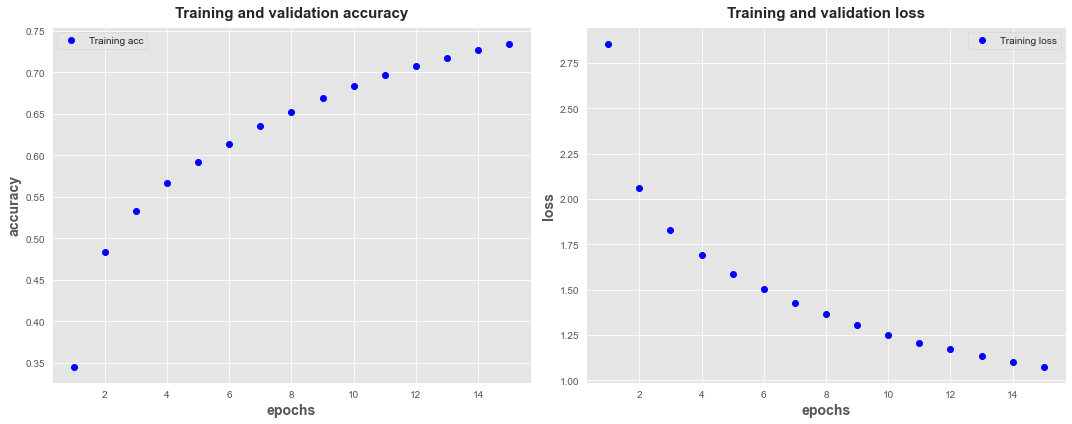

In [9]:
plot_loss_accuracy(history2)